In [41]:
from torch import nn
import torch
import matplotlib.pyplot as plt
import numpy as np


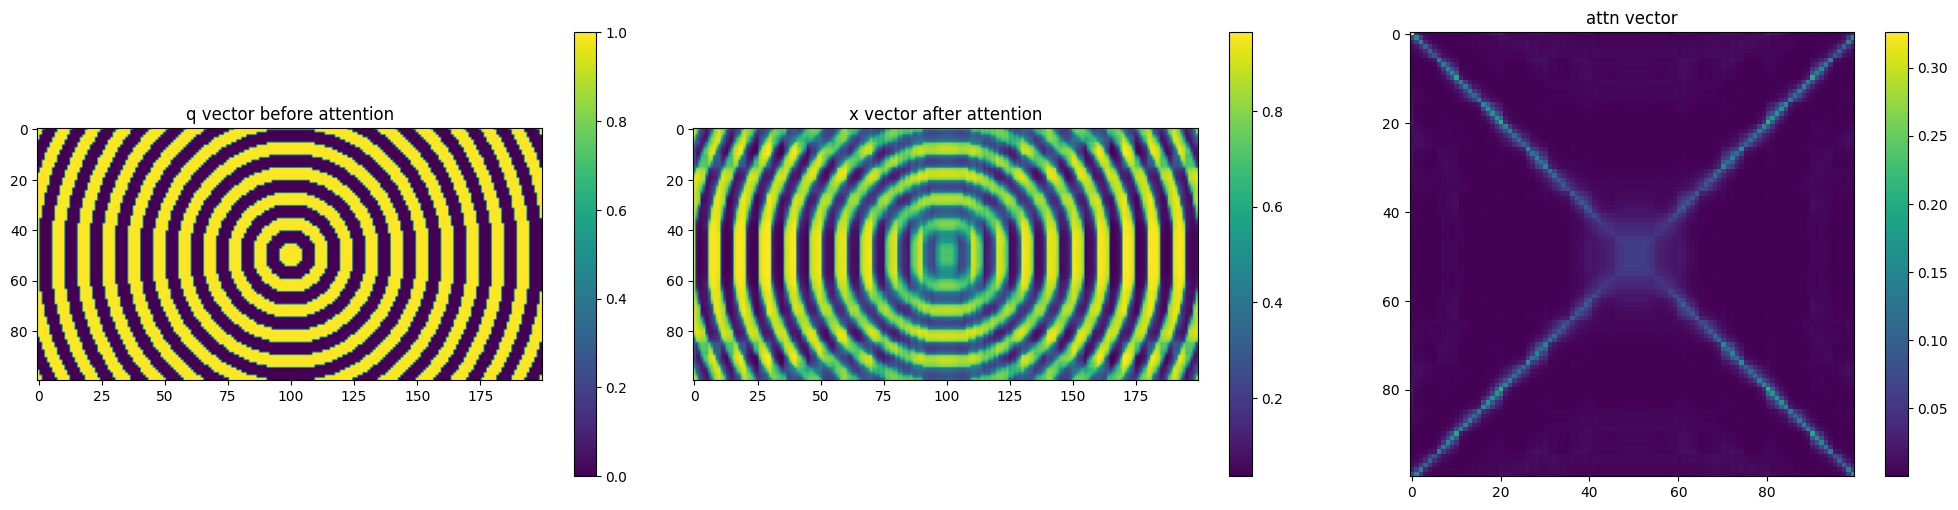

In [42]:
def attention(q, k, v):
    B, N, C = q.shape
    attn = (q @ k.transpose(1,2)) * (C ** -0.5) # scaling
    attn = attn.softmax(dim=-1)
    x = (attn @ v).reshape(B, N ,C)
    return x, attn

def generate_circle_tree_ring_tensor(B, N, C, separation):
    q = torch.zeros(B, N, C)
    center_y, center_x = N // 2, C // 2
    for y in range(N):
        for x in range(C):
            dist = ((x - center_x) ** 2 + (y - center_y) ** 2) ** 0.5
            if int(dist) % (2 * separation) < separation:  # separation units for the ring thickness
                q[0, y, x] = 1
    return q

def generate_square_tree_ring_tensor(B, N, C, separation):
    q = torch.zeros(B, N, C)
    center_y, center_x = N // 2, C // 2
    for y in range(N):
        for x in range(C):
            dist_y = abs(y - center_y)
            dist_x = abs(x - center_x)
            min_dist = min(dist_y, dist_x)
            if int(min_dist) % (2 * separation) < separation:  # separation units for the ring thickness
                q[0, y, x] = 1
    return q


def plot_tensors(q, x, attn):
    plt.figure(figsize=(20, 5))

    # Plot q vector
    plt.subplot(1, 3, 1)
    plt.imshow(q[0].detach().numpy(), cmap='viridis')
    plt.title('q vector before attention')
    plt.colorbar()

    # Plot x vector (after attention)
    plt.subplot(1, 3, 2)
    plt.imshow(x[0].detach().numpy(), cmap='viridis')
    plt.title('x vector after attention')
    plt.colorbar()

    # Plot attn vector
    plt.subplot(1, 3, 3)
    plt.imshow(attn[0].detach().numpy(), cmap='viridis')
    plt.title('attn vector')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

def main(separation=5, pattern='circle'):
    B, N, C = 1, 100, 200
    if pattern == 'circle':
        q = generate_circle_tree_ring_tensor(B, N, C, separation)
    elif pattern == 'square':
        q = generate_square_tree_ring_tensor(B, N, C, separation)
    else:
        raise ValueError("Invalid pattern. Choose either 'circle' or 'square'.")
    
    k = q.clone()
    v = q.clone()

    x, attn = attention(q, k, v)
    plot_tensors(q, x, attn)

# Example usage
main(separation=5, pattern='circle')





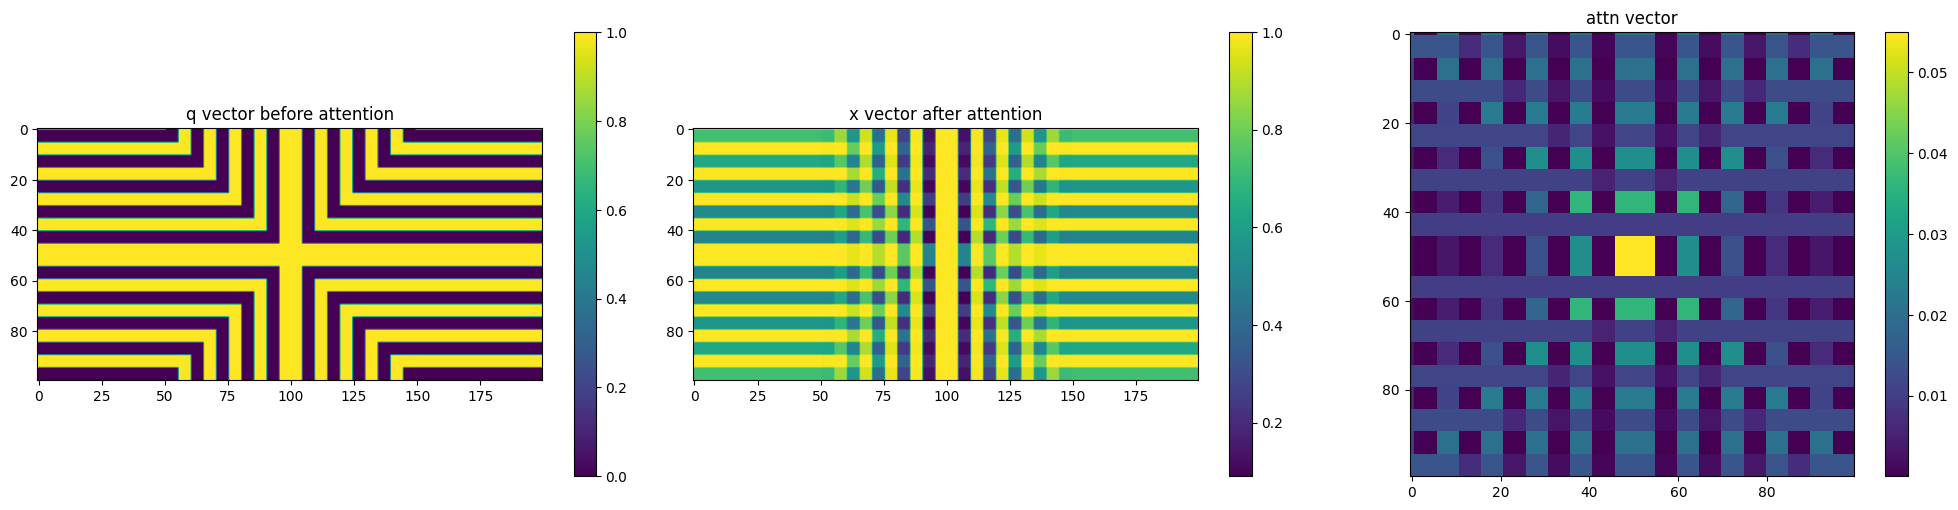

In [43]:

main(separation=5, pattern='square')


Epoch 1/10, Loss: 0.25081024087965487


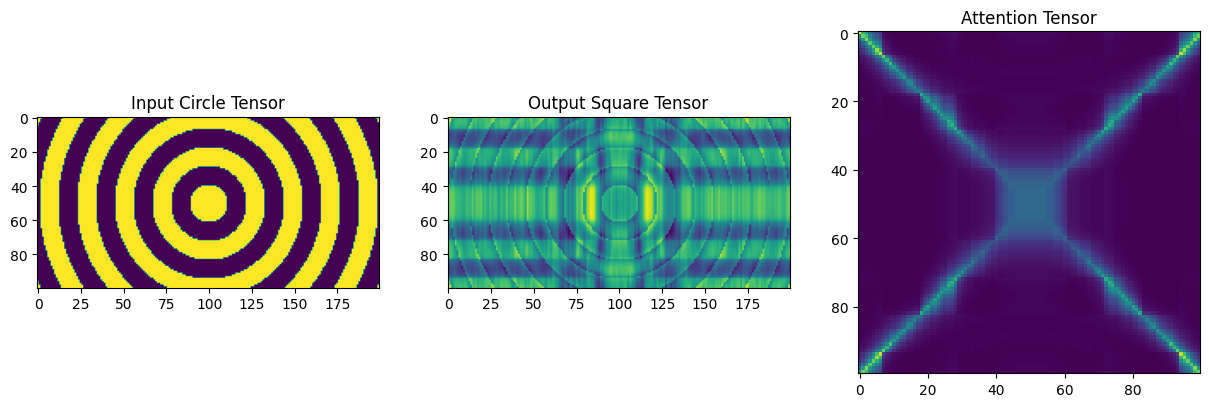

Epoch 2/10, Loss: 0.16927994430065155


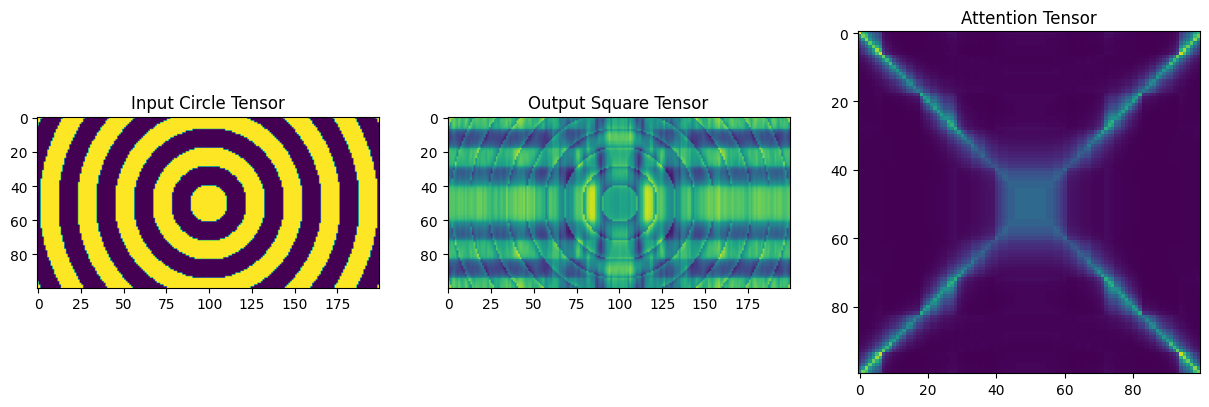

Epoch 3/10, Loss: 0.15917787089943886


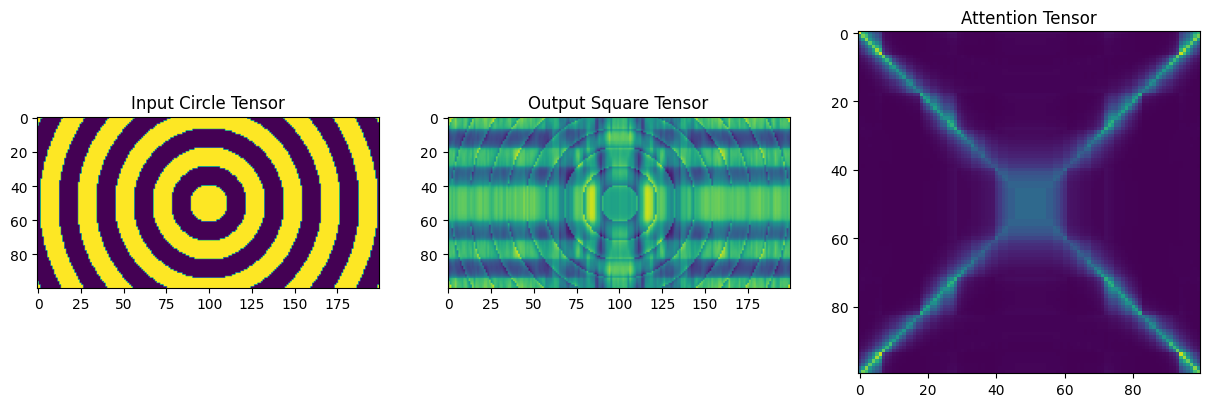

Epoch 4/10, Loss: 0.15357277289032936


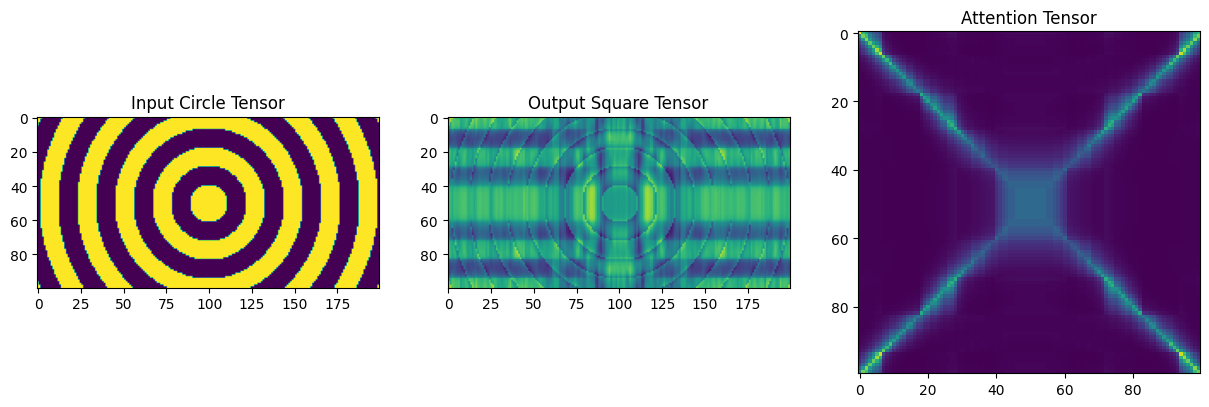

Epoch 5/10, Loss: 0.15073176398873328


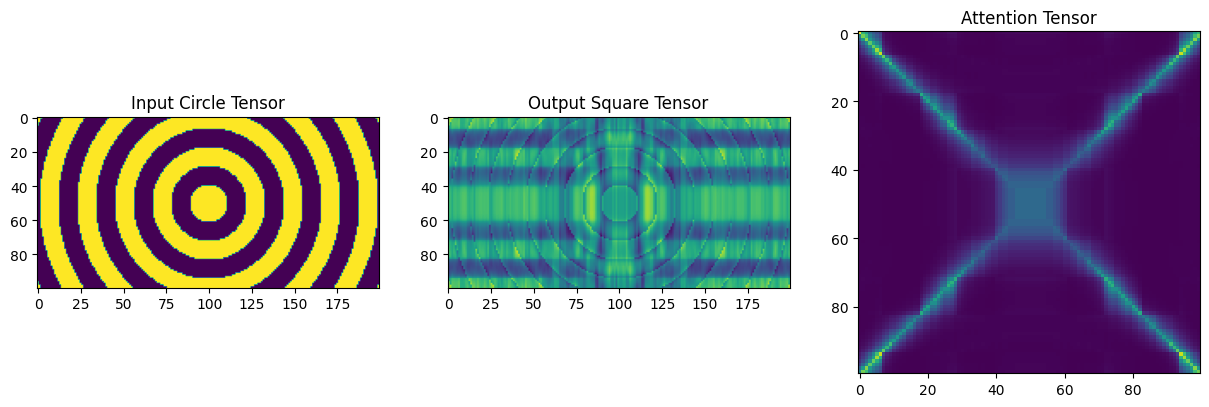

Epoch 6/10, Loss: 0.14864481590688228


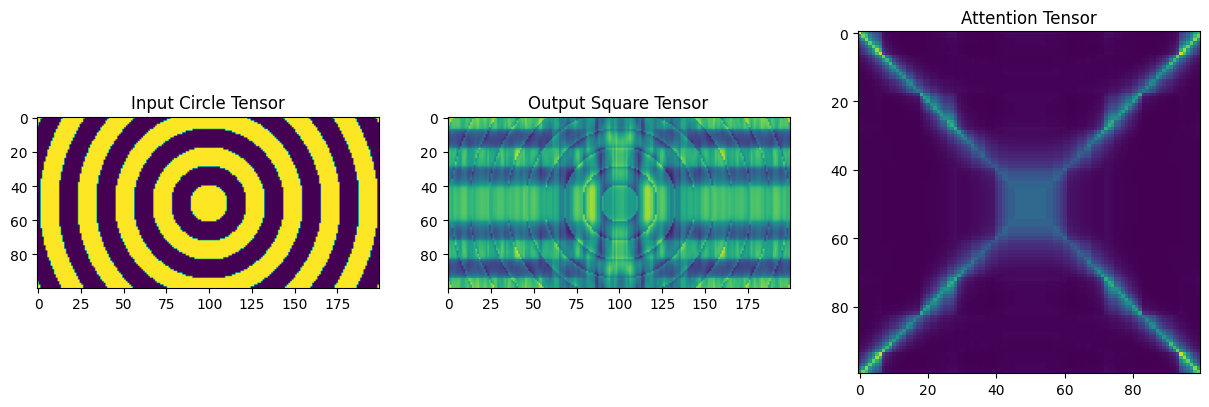

Epoch 7/10, Loss: 0.14627867601811886


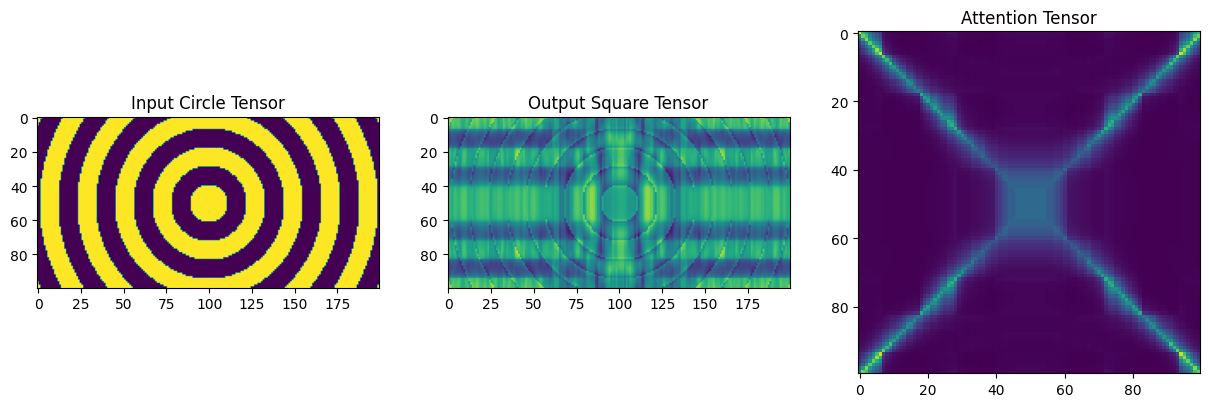

Epoch 8/10, Loss: 0.14383890643715858


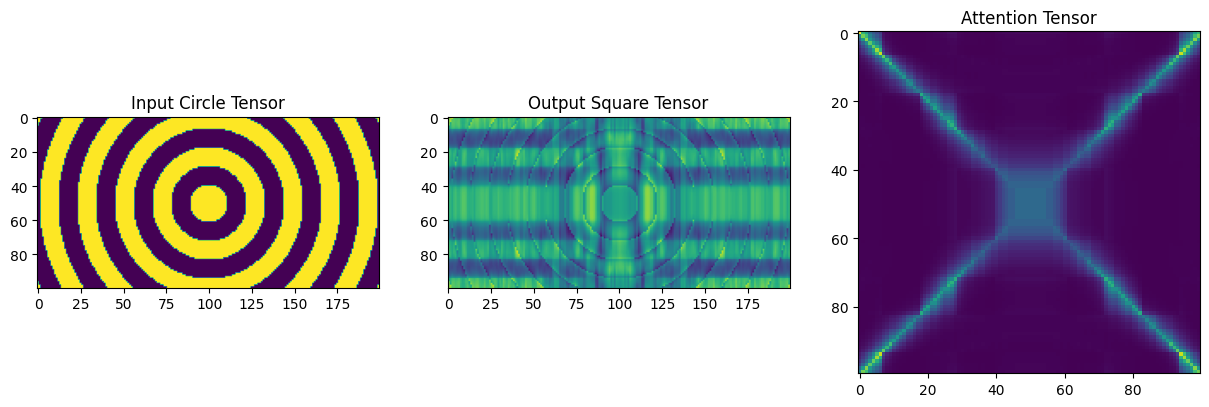

Epoch 9/10, Loss: 0.14171467266976834


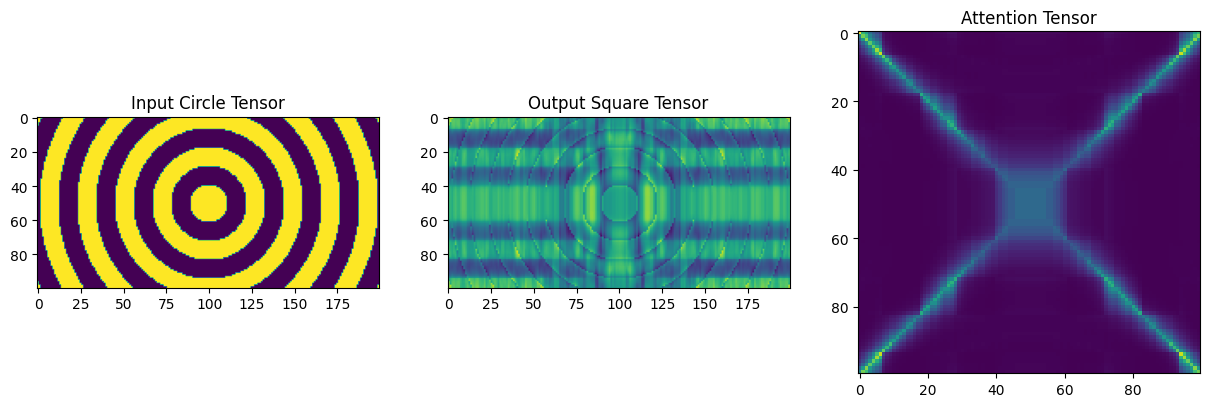

Epoch 10/10, Loss: 0.14001517064869404


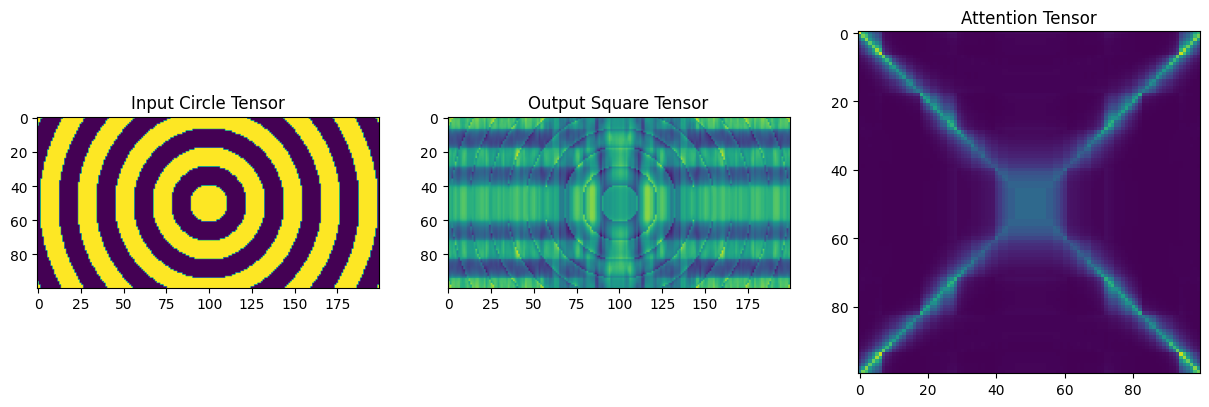

In [44]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

def generate_circle_tree_ring_tensor(N, C, separation):
    q = torch.zeros(N, C)
    center_y, center_x = N // 2, C // 2
    for y in range(N):
        for x in range(C):
            dist = ((x - center_x) ** 2 + (y - center_y) ** 2) ** 0.5
            if int(dist) % (2 * separation) < separation:
                q[y, x] = 1
    return q

def generate_square_tree_ring_tensor(N, C, separation):
    q = torch.zeros(N, C)
    center_y, center_x = N // 2, C // 2
    for y in range(N):
        for x in range(C):
            dist_y = abs(y - center_y)
            dist_x = abs(x - center_x)
            min_dist = min(dist_y, dist_x)
            if int(min_dist) % (2 * separation) < separation:
                q[y, x] = 1
    return q

def generate_dataset(num_samples, N, C, min_separation, max_separation):
    dataset = []
    for _ in range(num_samples):
        separation = random.randint(min_separation, max_separation)
        circle_tensor = generate_circle_tree_ring_tensor(N, C, separation)
        square_tensor = generate_square_tree_ring_tensor(N, C, separation)
        dataset.append((circle_tensor, square_tensor))
    return dataset

# Example usage
dataset = generate_dataset(100, 100, 200, 5, 15)

# Define the attention mechanism
class Attention(nn.Module):
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.dim = dim

    def forward(self, q, k, v):
        B, N, C = q.shape
        attn = (q @ k.transpose(1,2)) * (self.dim ** -0.5) # scaling
        attn = attn.softmax(dim=-1)
        x = (attn @ v).reshape(B, N ,C)
        return x, attn

# Define the neural network
class Net(nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()
        self.attention = Attention(dim)
        self.fc = nn.Linear(dim, dim)

    def forward(self, q, k, v):
        x, attn = self.attention(q, k, v)
        x = self.fc(x)
        x = x + q
        return x, attn

# Training function
def train(model, dataset, epochs=10, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for circle_tensor, square_tensor in dataset:
            circle_tensor = circle_tensor.unsqueeze(0)
            square_tensor = square_tensor.unsqueeze(0)
            
            optimizer.zero_grad()
            output, attn = model(circle_tensor, circle_tensor, circle_tensor)
            loss = criterion(output, square_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataset)}")

        # Visualize the tensors
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(circle_tensor[0].detach().numpy(), cmap='viridis')
        plt.title('Input Circle Tensor')
        
        plt.subplot(1, 3, 2)
        plt.imshow(output[0].detach().numpy(), cmap='viridis')
        plt.title('Output Square Tensor')
        
        plt.subplot(1, 3, 3)
        plt.imshow(attn[0].detach().numpy(), cmap='viridis')
        plt.title('Attention Tensor')
        
        plt.show()

# Initialize and train the model
model = Net(200)
train(model, dataset, epochs=10)


Epoch 1/10, Loss: 1.512380074262619


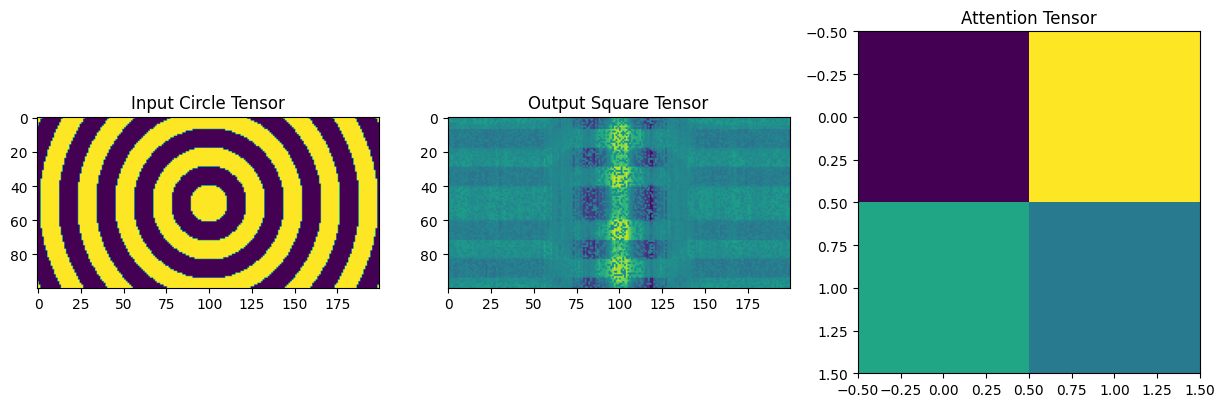

Epoch 2/10, Loss: 1.0869971388578414


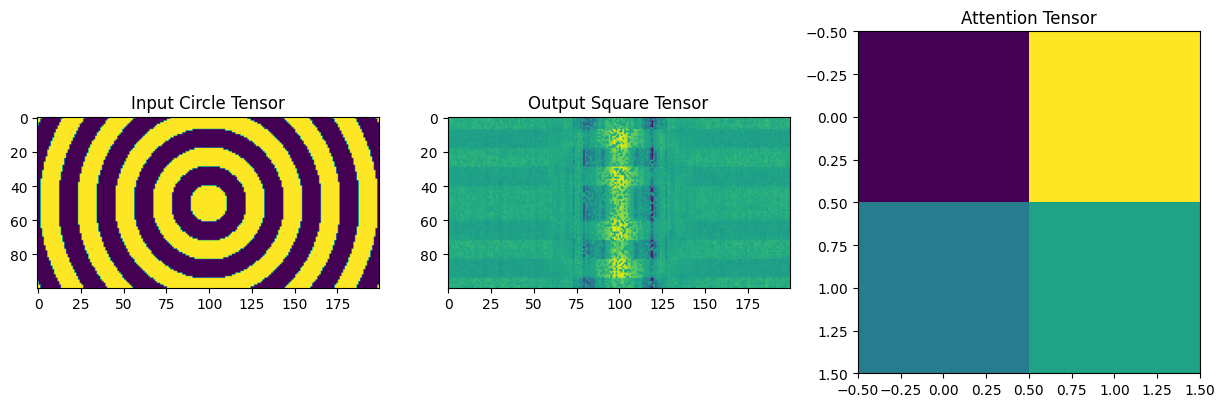

Epoch 3/10, Loss: 0.7562140876054764


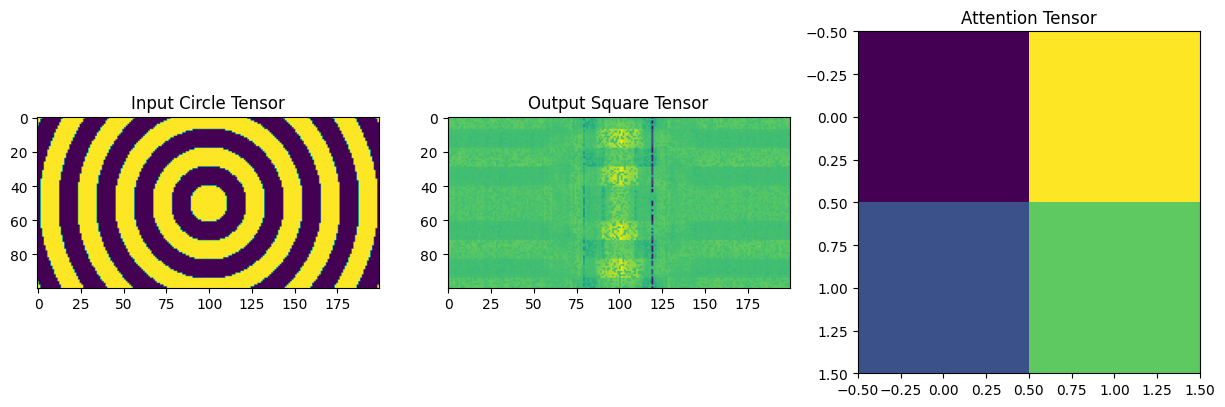

Epoch 4/10, Loss: 0.4926025366783142


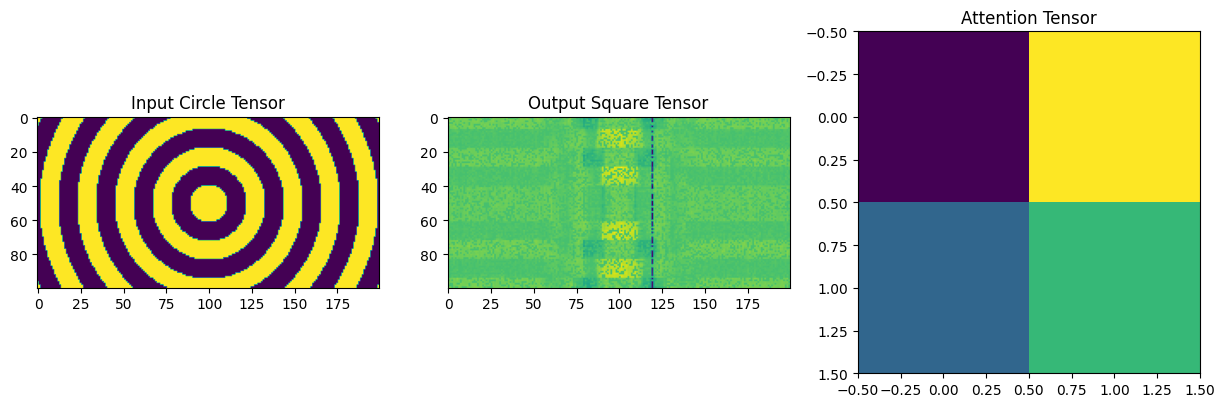

Epoch 5/10, Loss: 0.37048798859119414


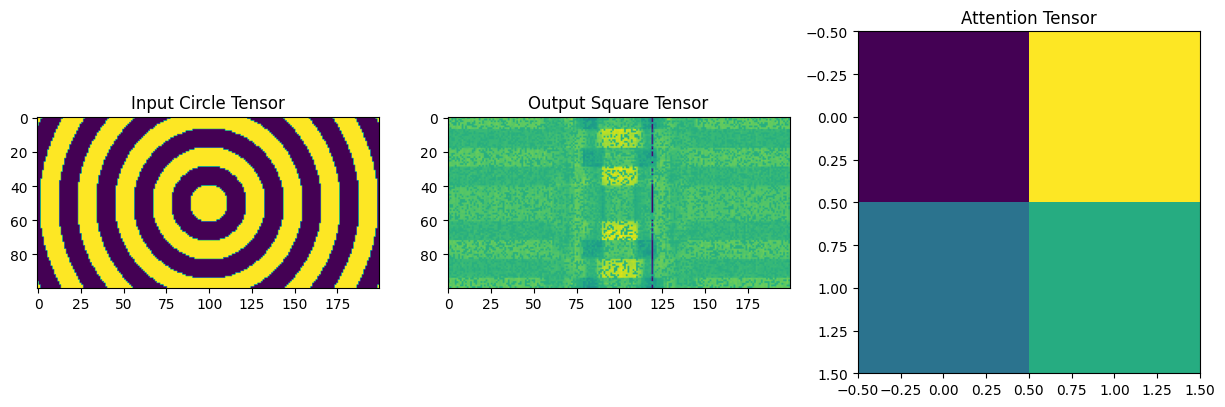

Epoch 6/10, Loss: 0.31663052678108217


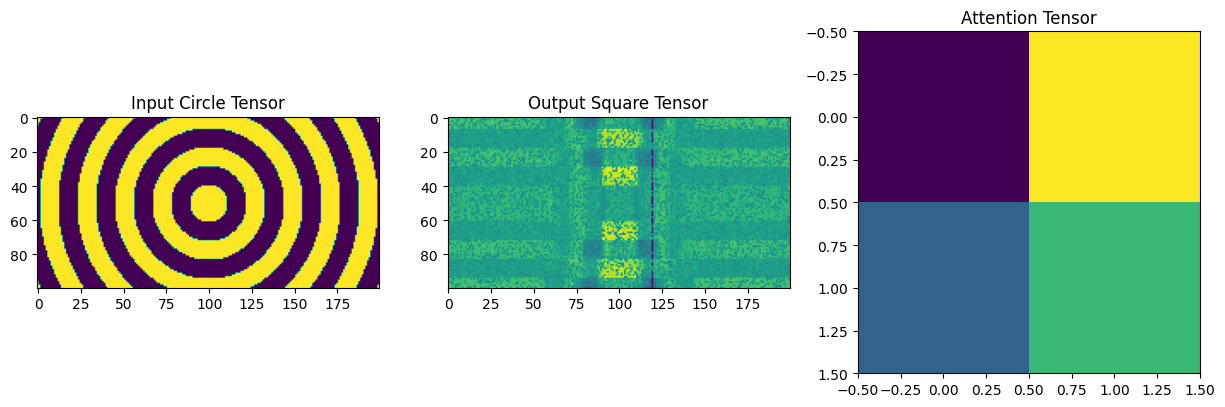

Epoch 7/10, Loss: 0.2913113856315613


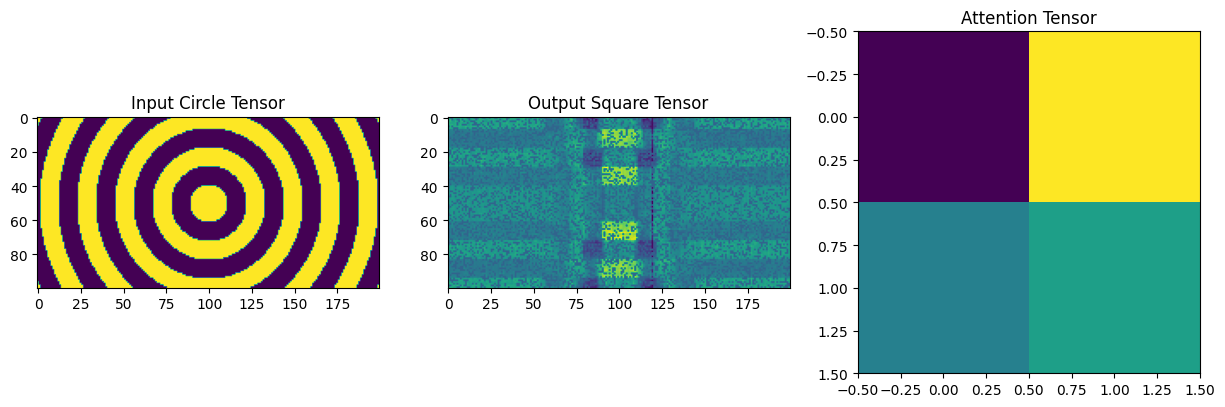

Epoch 8/10, Loss: 0.2785483580827713


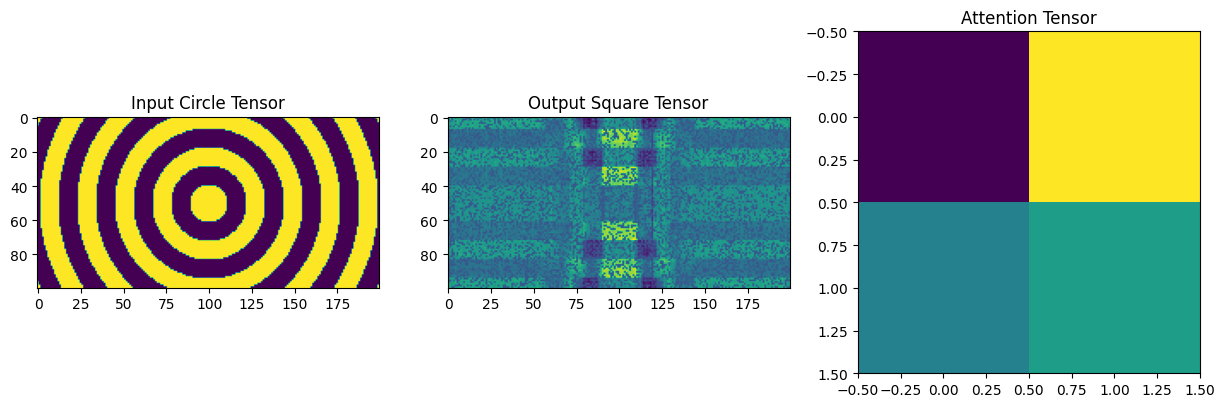

Epoch 9/10, Loss: 0.2715554454922676


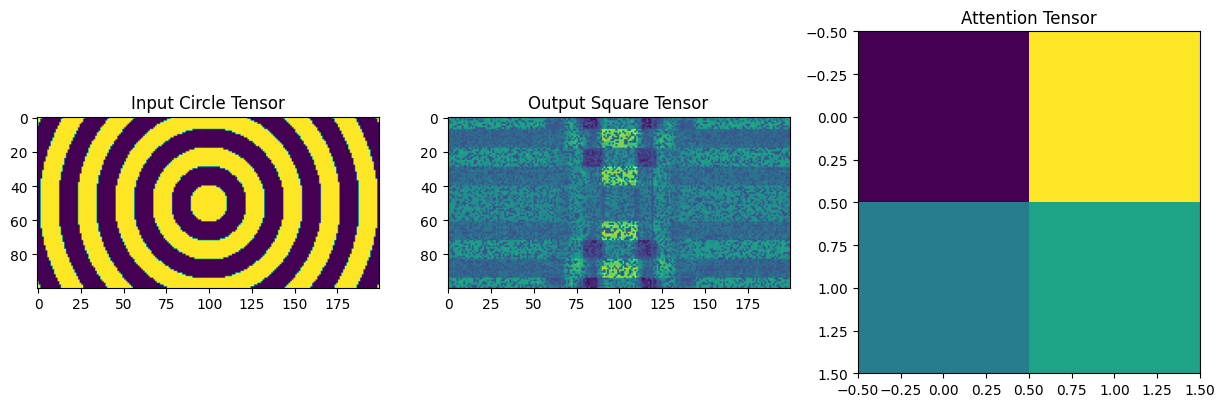

Epoch 10/10, Loss: 0.2652419689297676


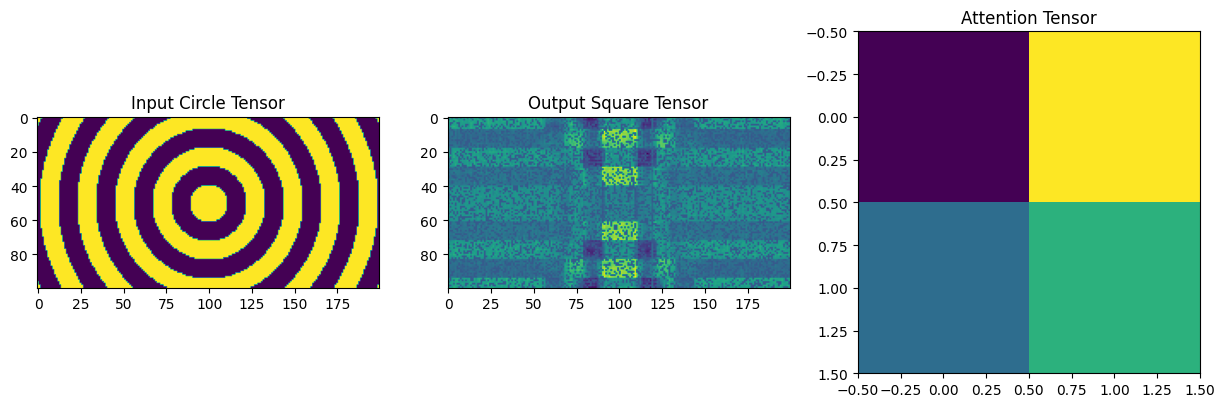

In [45]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Self Attention mechanism
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, queries):
        N = queries.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Scaled dot-product attention
        attn = (queries @ keys.transpose(2, 3)) / self.head_dim ** 0.5
        attn = attn.softmax(dim=3)
        out = attn @ values
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        return self.fc_out(out), attn

# Transformer Block (Encoder)
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention_out, attn = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention_out + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, attn

# Training function
def train(model, dataset, epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for circle_tensor, square_tensor in dataset:
            circle_tensor = circle_tensor.unsqueeze(0)
            square_tensor = square_tensor.unsqueeze(0)
            
            optimizer.zero_grad()
            output, attn = model(circle_tensor, circle_tensor, circle_tensor)
            loss = criterion(output, square_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataset)}")

        # Visualize the tensors
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(circle_tensor[0].detach().numpy(), cmap='viridis')
        plt.title('Input Circle Tensor')
        
        plt.subplot(1, 3, 2)
        plt.imshow(output[0].detach().numpy(), cmap='viridis')
        plt.title('Output Square Tensor')
        
        plt.subplot(1, 3, 3)
        plt.imshow(attn[0][0].detach().numpy(), cmap='viridis')
        plt.title('Attention Tensor')
        
        plt.show()

# Initialize and train the model
model = TransformerBlock(embed_size=200, heads=2, dropout=0.3, forward_expansion=4)
train(model, dataset, epochs=10)


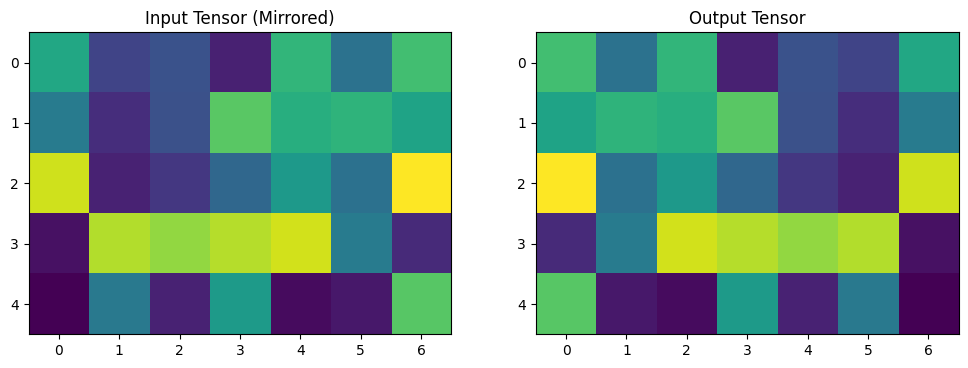

In [46]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class MirroredDataset(Dataset):
    def __init__(self, length=1000):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Generate a random tensor of size 100x200 for output
        output_tensor = torch.rand(5, 7)
        
        # Create the mirrored version for input
        input_tensor = torch.flip(output_tensor, [1])
        
        return input_tensor, output_tensor

# Create the dataset
dataset = MirroredDataset()

# Get a sample from the dataset
input_tensor, output_tensor = dataset[0]

# Visualize the tensors using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_tensor, cmap='viridis')
ax[0].set_title('Input Tensor (Mirrored)')

ax[1].imshow(output_tensor, cmap='viridis')
ax[1].set_title('Output Tensor')

plt.show()


In [47]:
def generate_dataset(num_samples, seq_dim):
    dataset = []
    for _ in range(num_samples):
        # Generate a random tensor of size 100x200 for output
        output_tensor = torch.rand(28,seq_dim)
        
        # Create the mirrored version for input
        input_tensor = torch.flip(output_tensor, [1])
        dataset.append((input_tensor, output_tensor))
    return dataset

Epoch 1/30, Loss: 0.2960006703287363


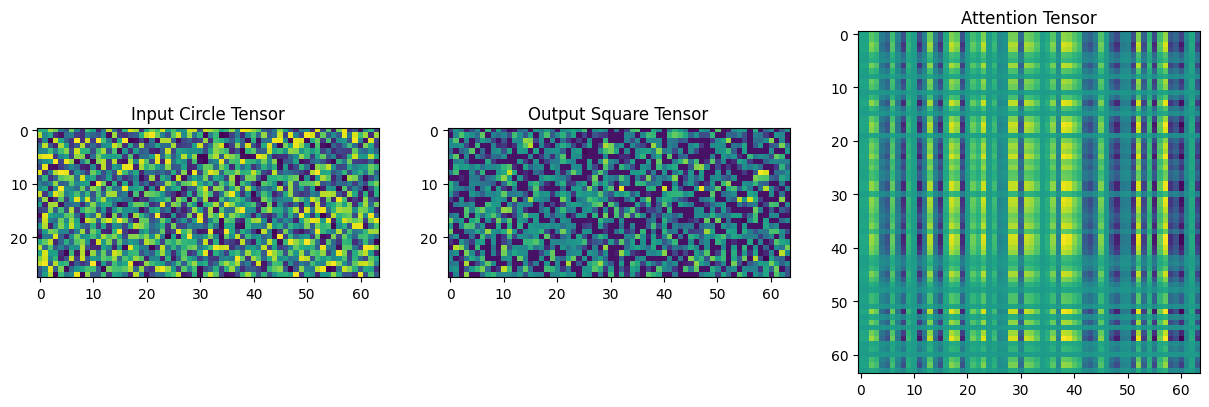

Epoch 2/30, Loss: 0.12132241072133183


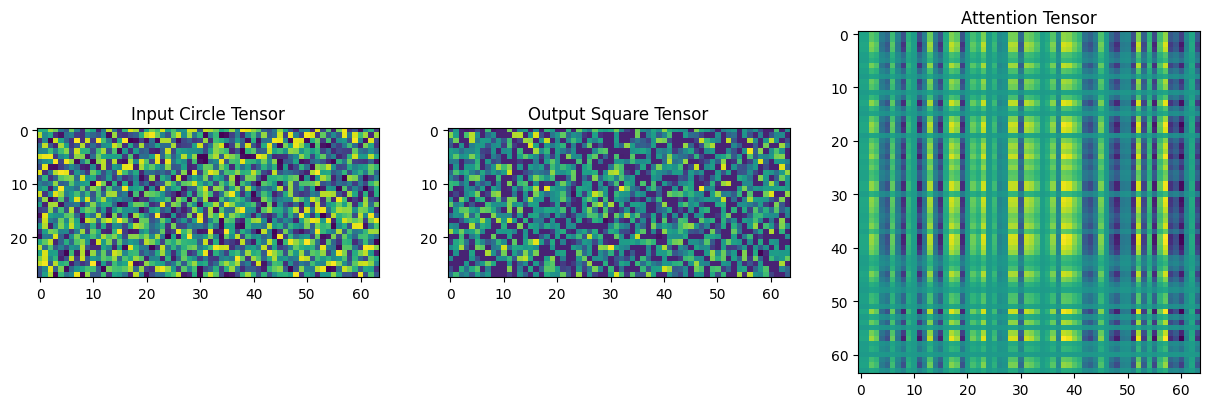

Epoch 3/30, Loss: 0.1201764113008976


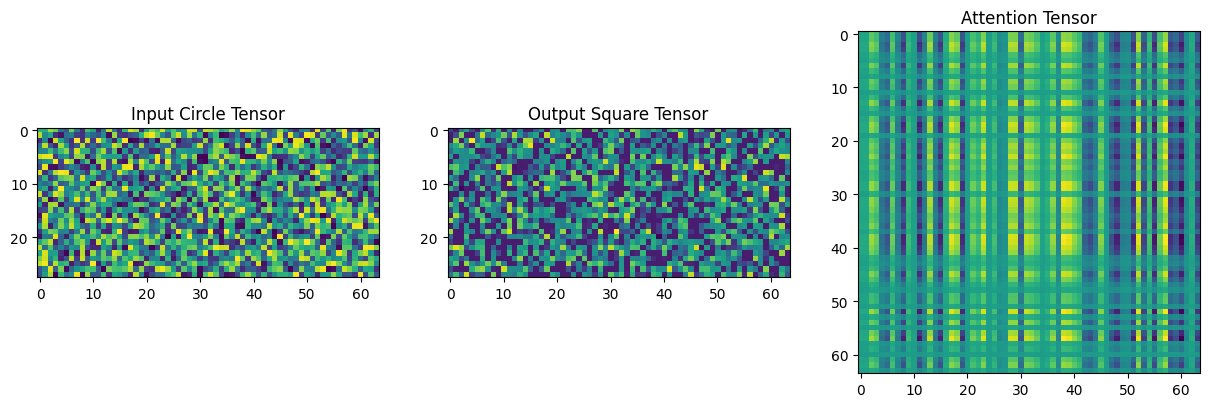

Epoch 4/30, Loss: 0.11944994236528873


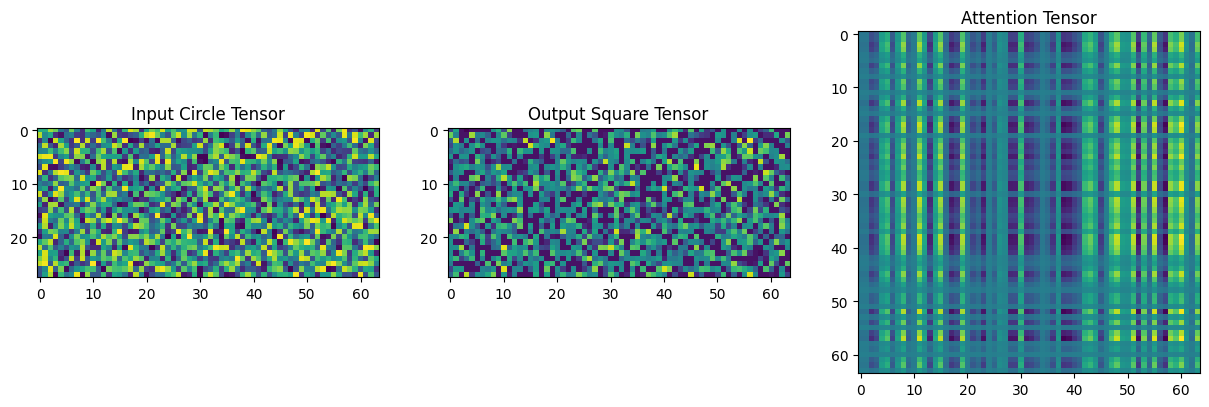

Epoch 5/30, Loss: 0.11968356797099114


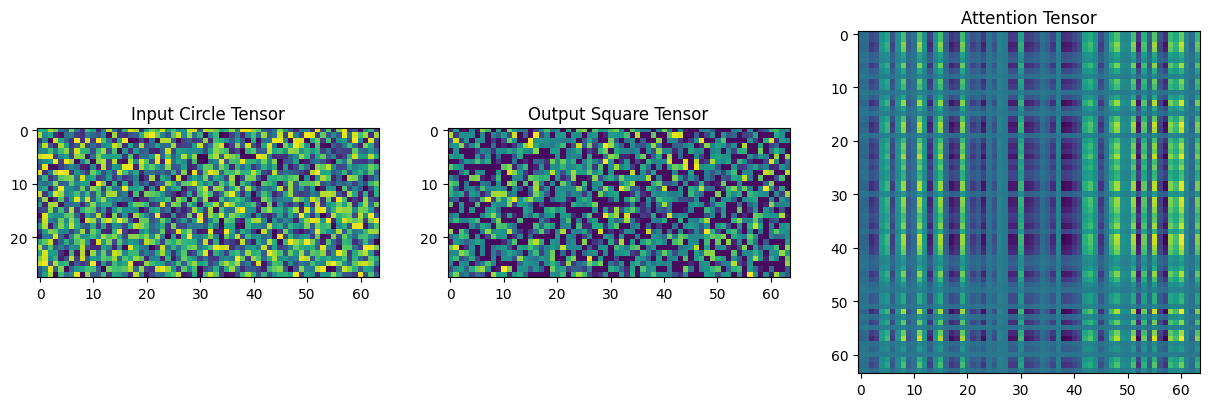

Epoch 6/30, Loss: 0.11953742428869009


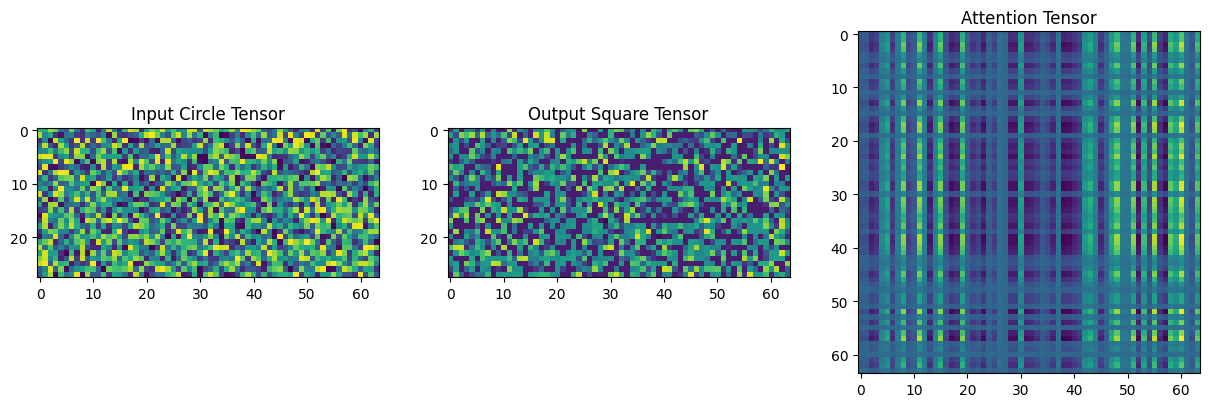

Epoch 7/30, Loss: 0.11925612619146704


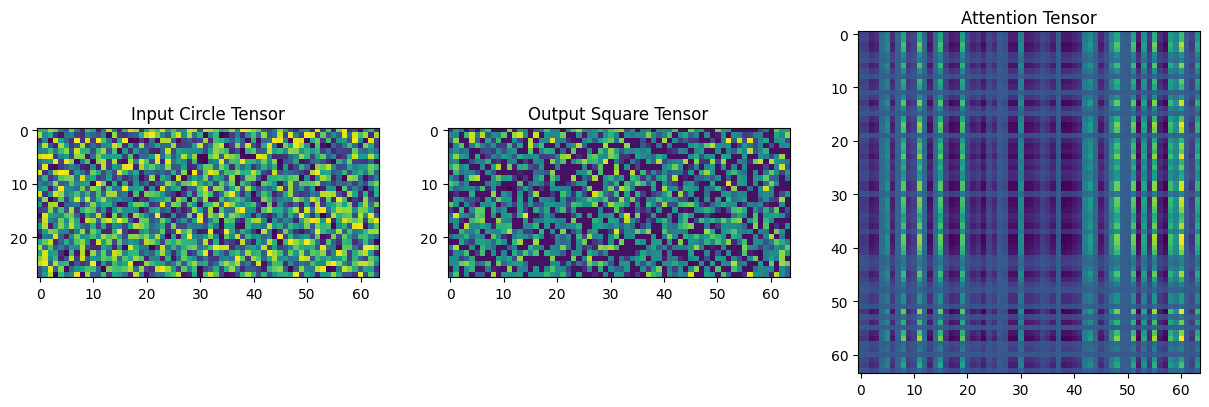

Epoch 8/30, Loss: 0.11930980400368571


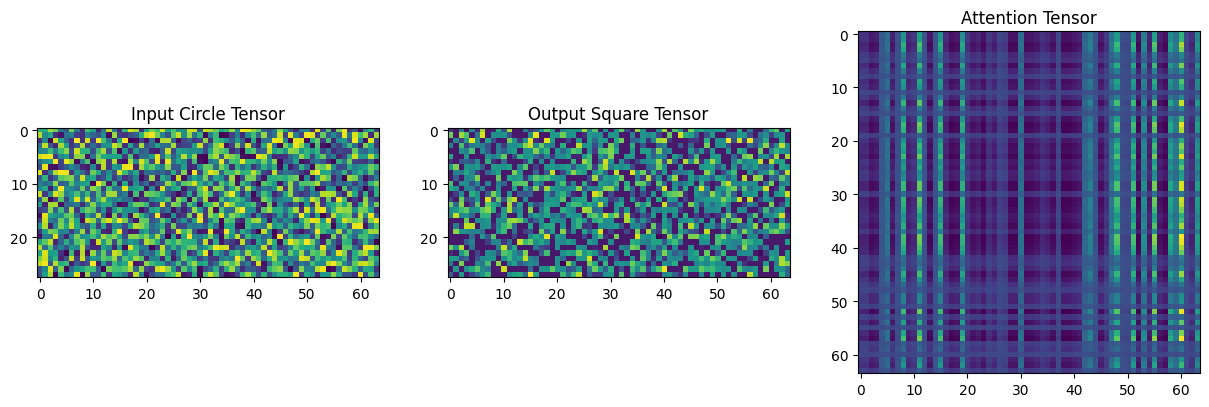

Epoch 9/30, Loss: 0.11932939536496998


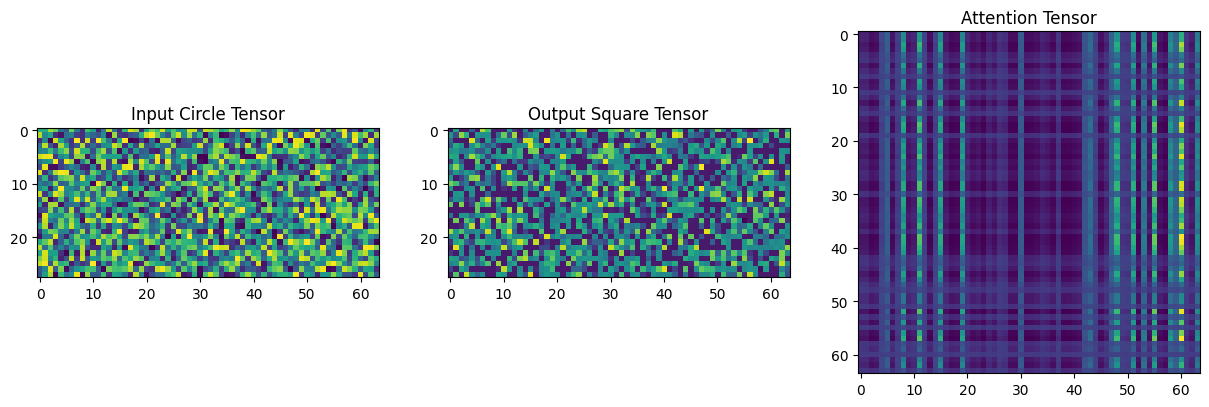

Epoch 10/30, Loss: 0.11910675862431526


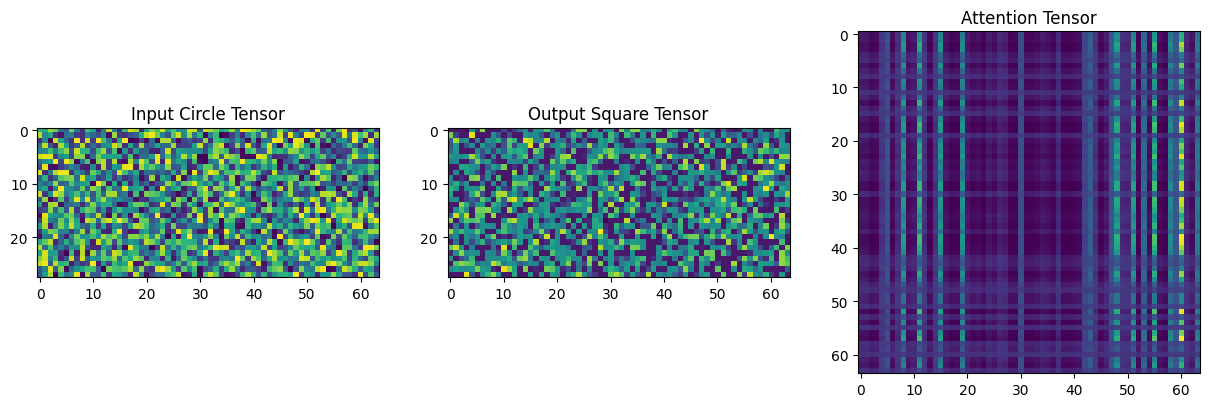

Epoch 11/30, Loss: 0.11924645925685763


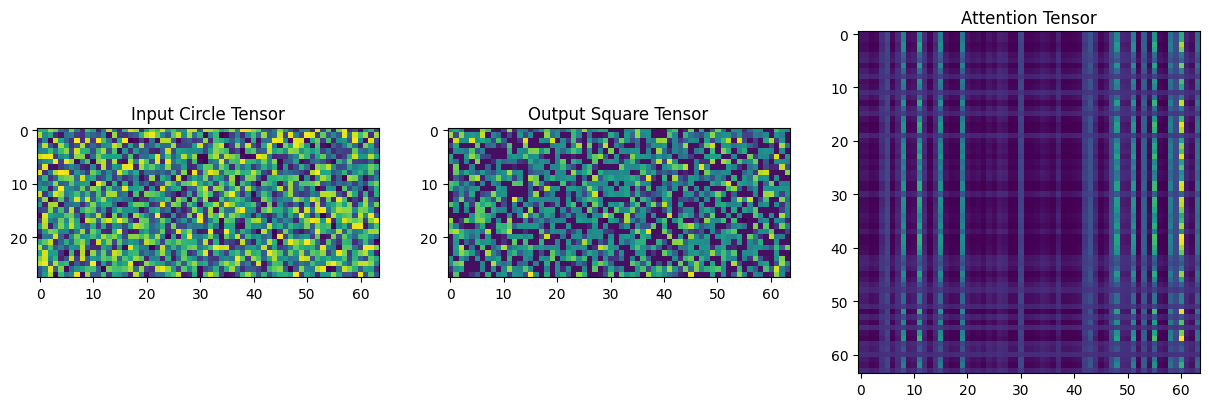

Epoch 12/30, Loss: 0.11927625434845686


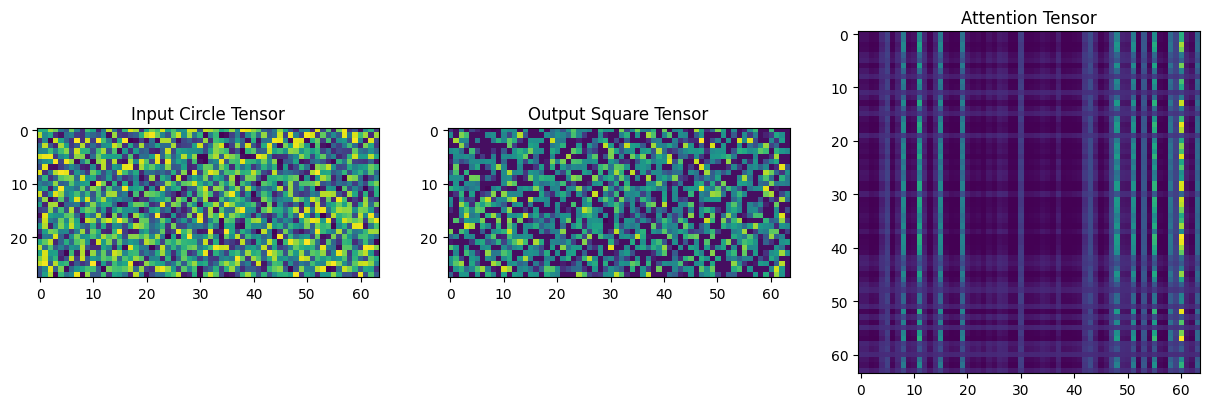

Epoch 13/30, Loss: 0.11911493832990527


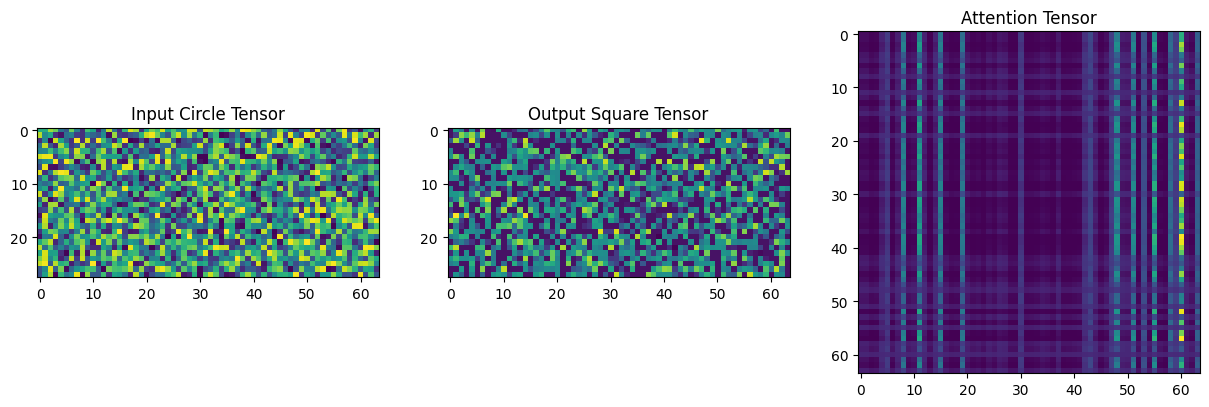

Epoch 14/30, Loss: 0.11922254126891493


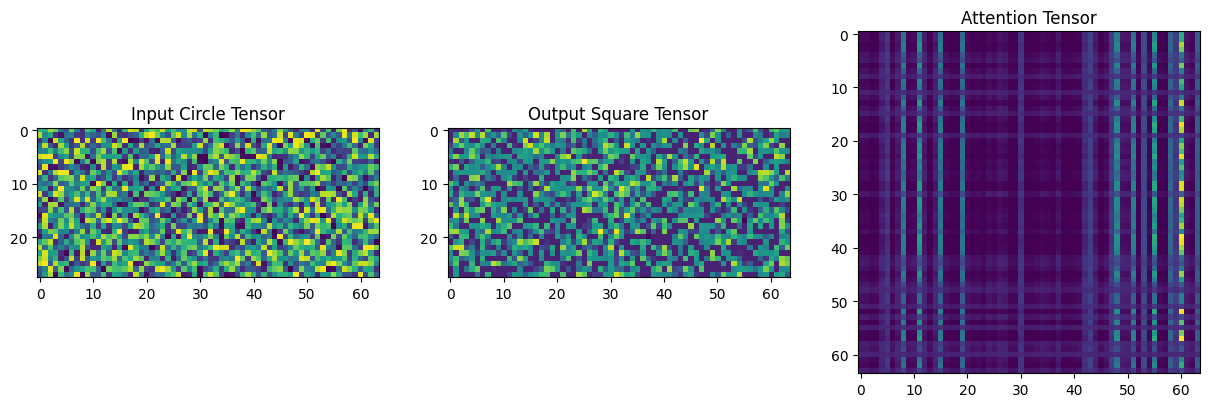

Epoch 15/30, Loss: 0.11909911872819066


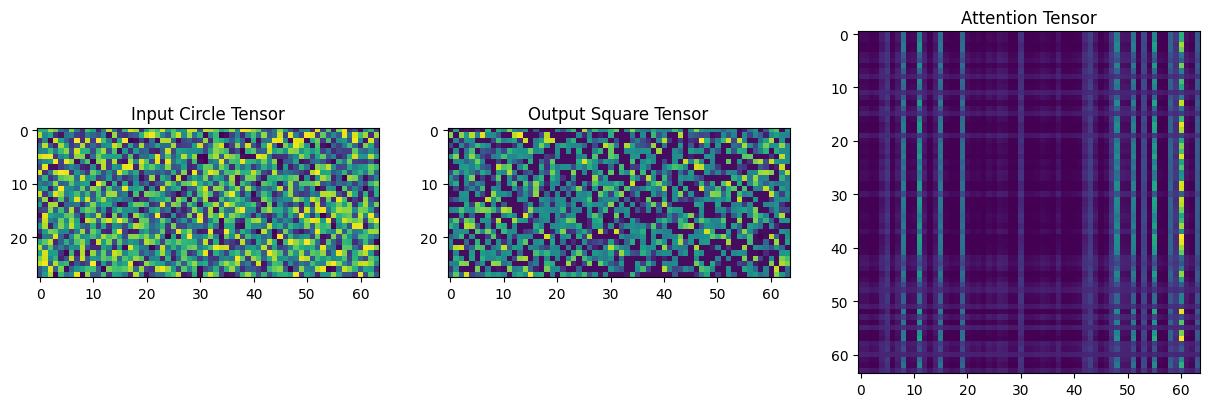

Epoch 16/30, Loss: 0.11900390706211328


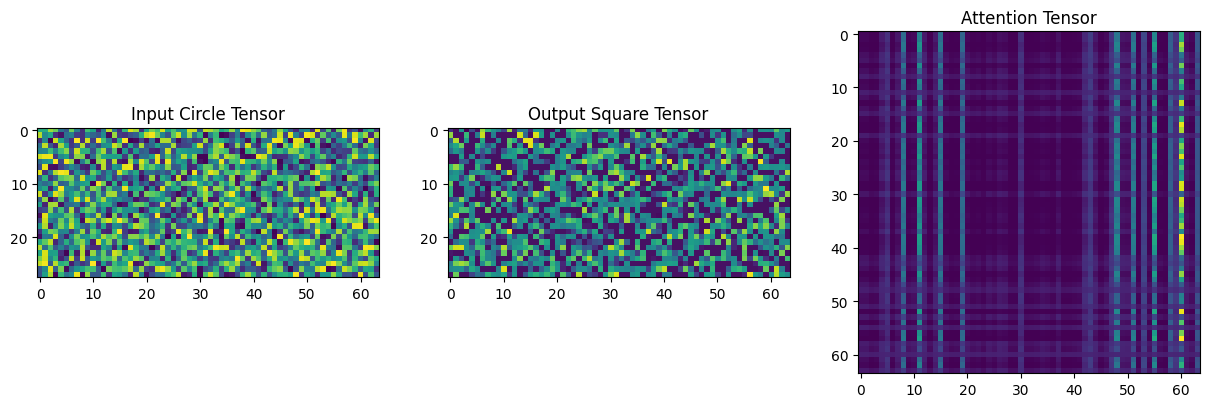

Epoch 17/30, Loss: 0.11917018307000399


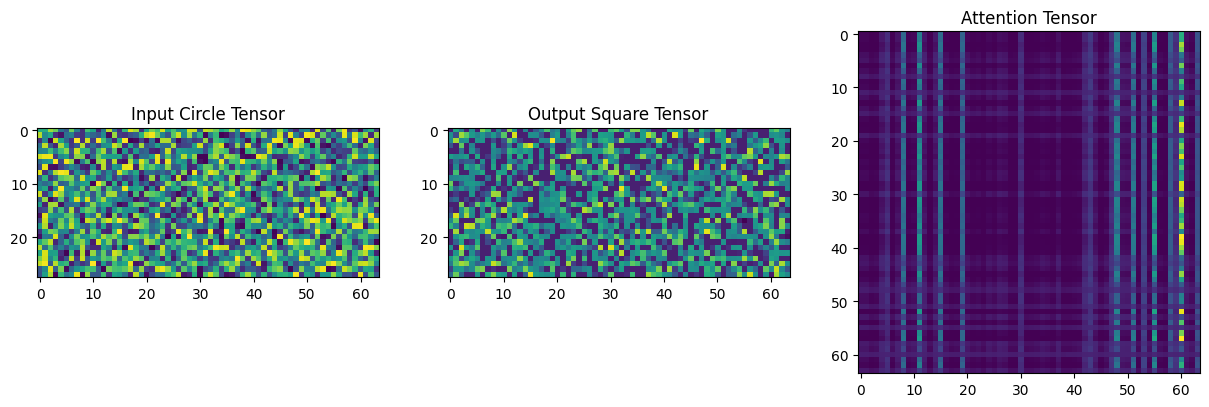

Epoch 18/30, Loss: 0.11889554100483656


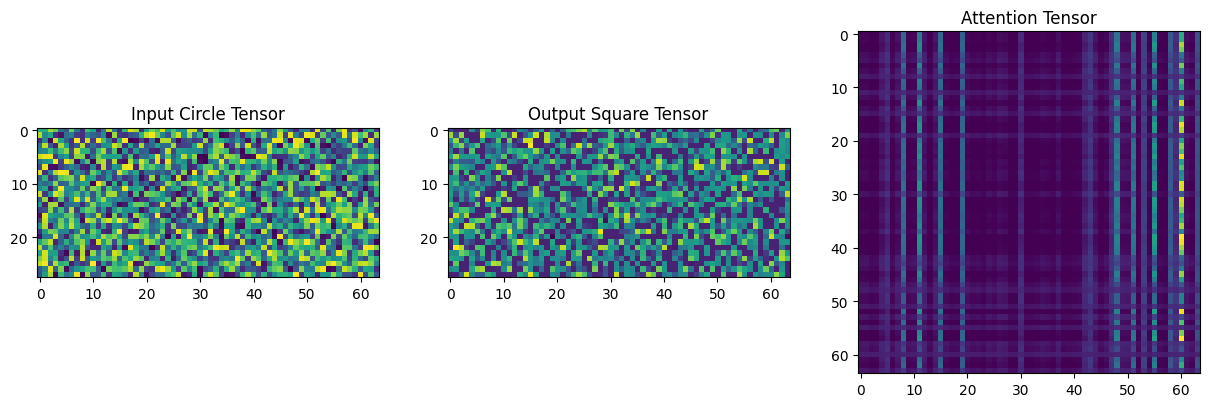

Epoch 19/30, Loss: 0.11887489899247884


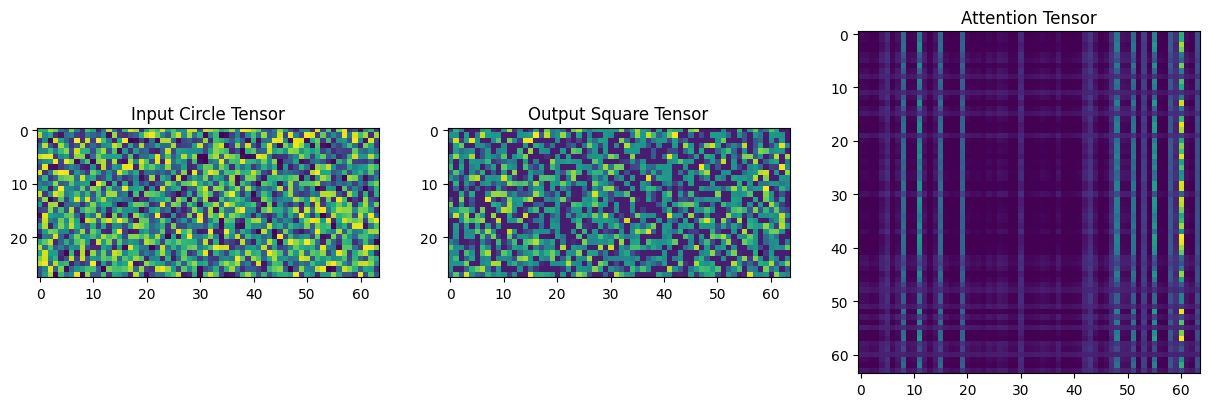

Epoch 20/30, Loss: 0.11904653970524669


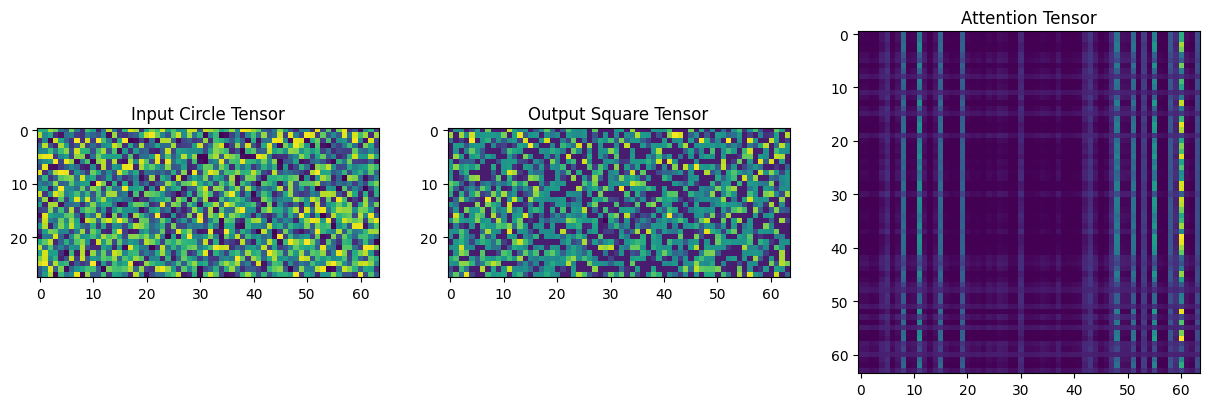

Epoch 21/30, Loss: 0.1190648134239018


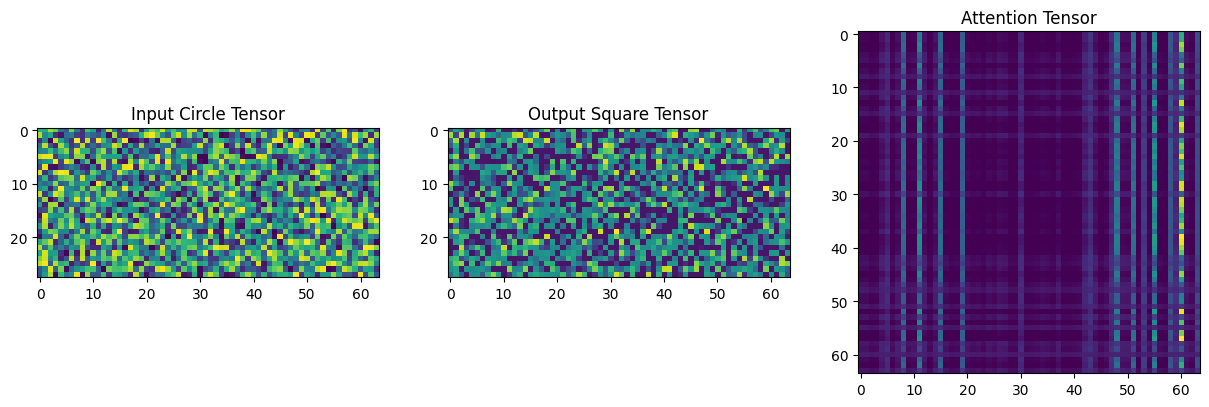

Epoch 22/30, Loss: 0.11897671112418175


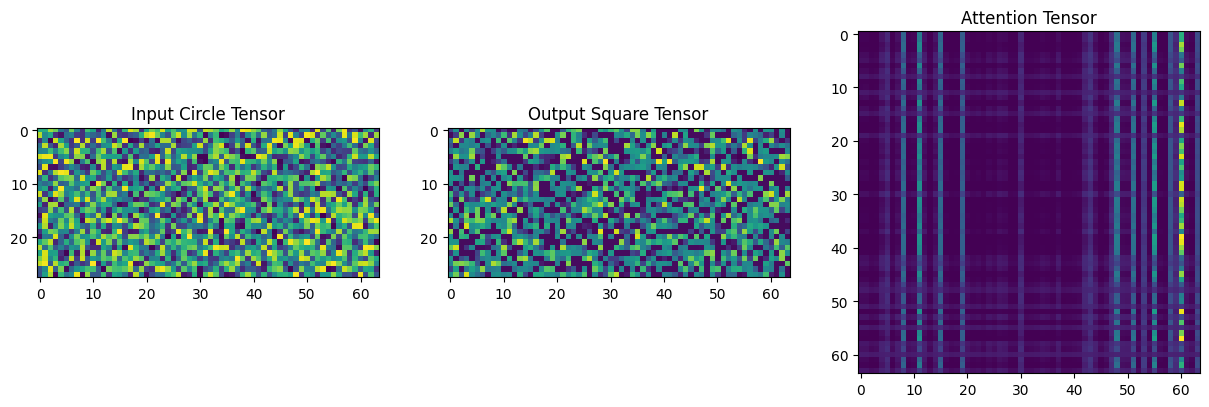

Epoch 23/30, Loss: 0.11893878247216344


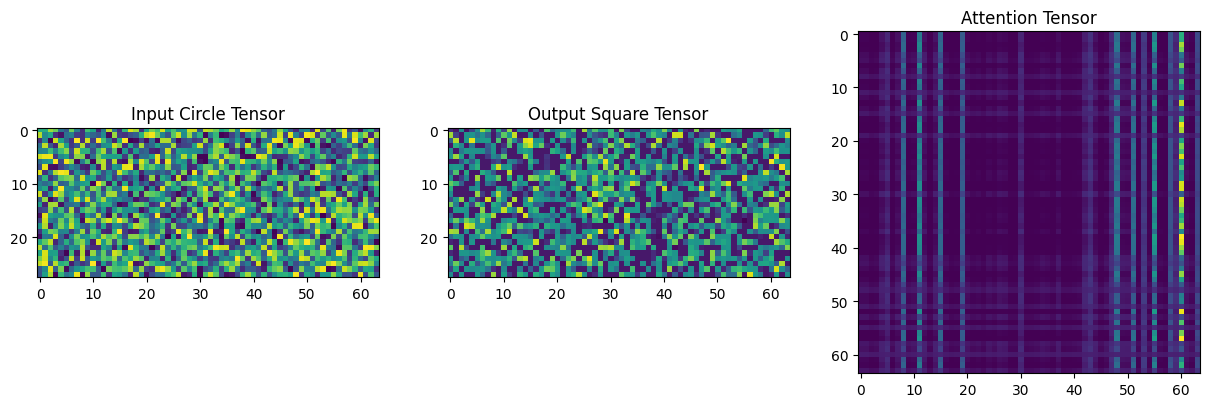

Epoch 24/30, Loss: 0.11889322435110808


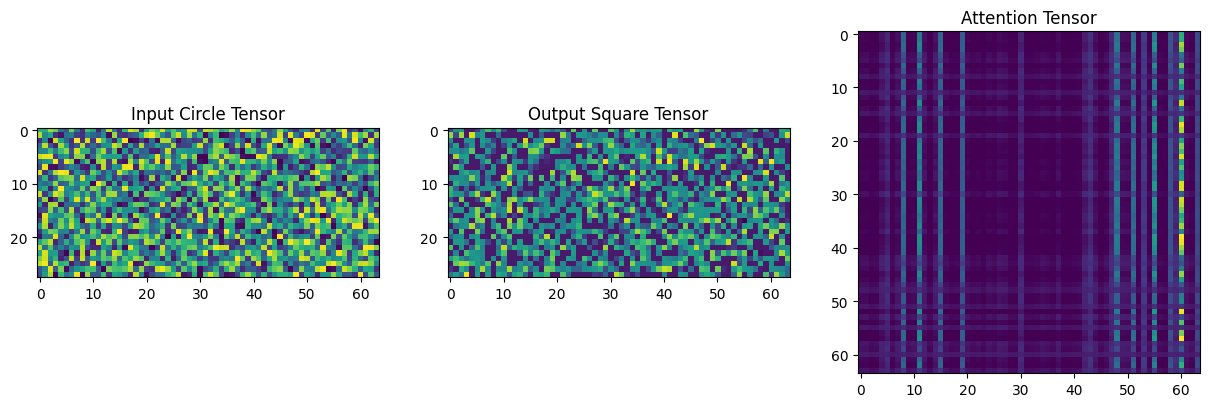

Epoch 25/30, Loss: 0.11898505153506994


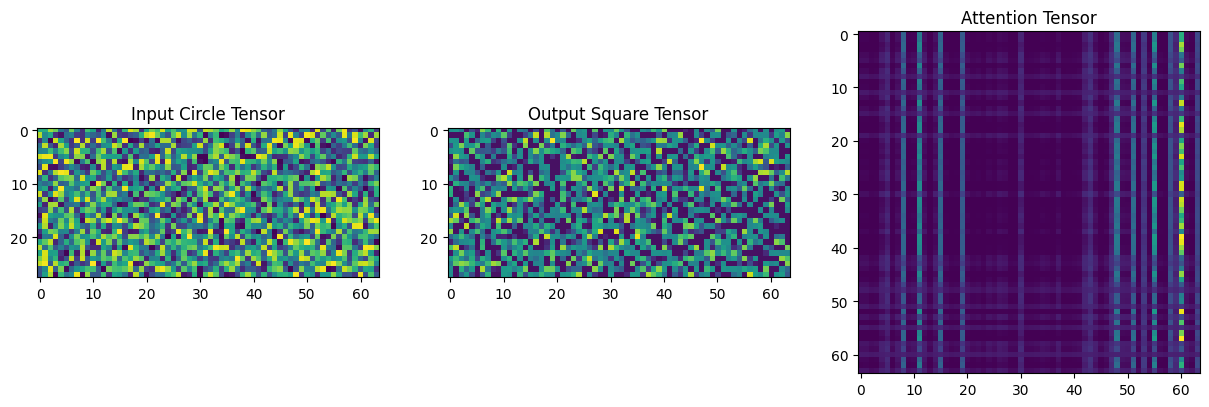

Epoch 26/30, Loss: 0.11898686823993922


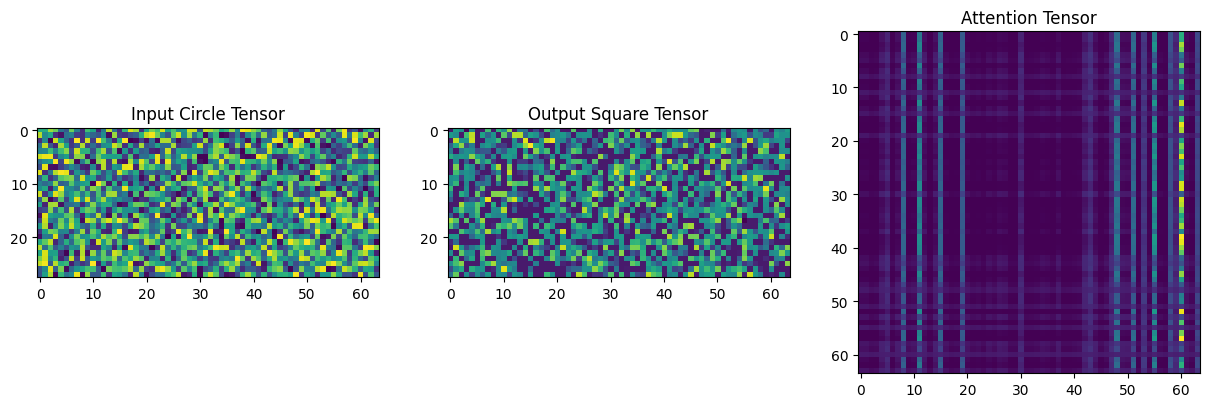

Epoch 27/30, Loss: 0.11888603087887167


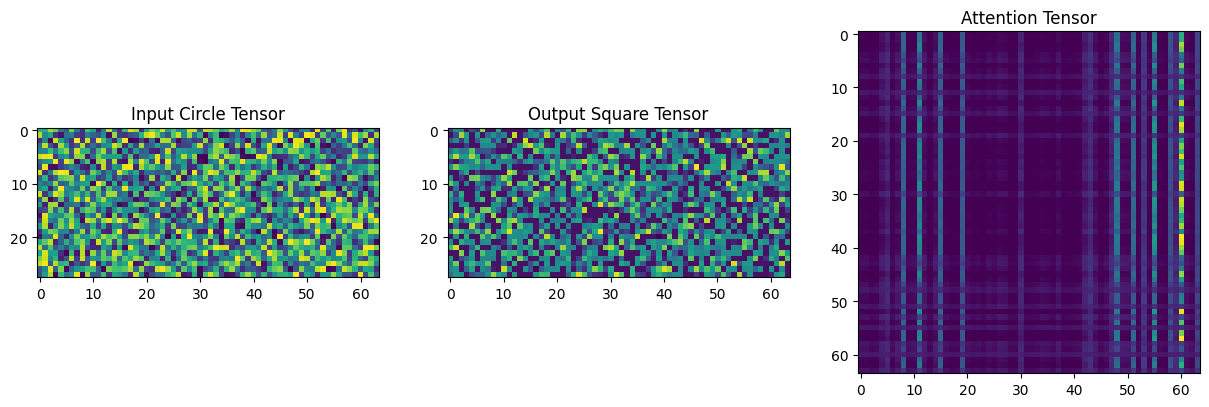

Epoch 28/30, Loss: 0.11877581349015236


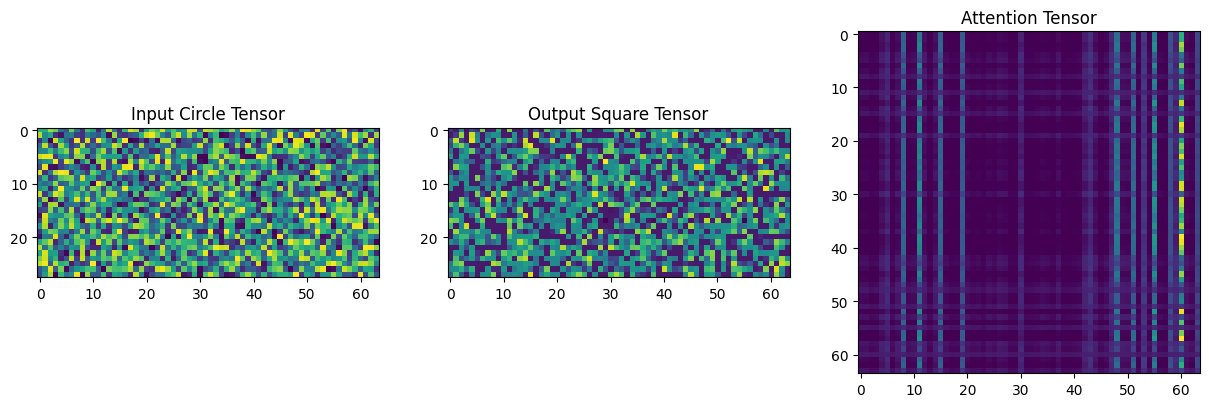

Epoch 29/30, Loss: 0.11906178856641055


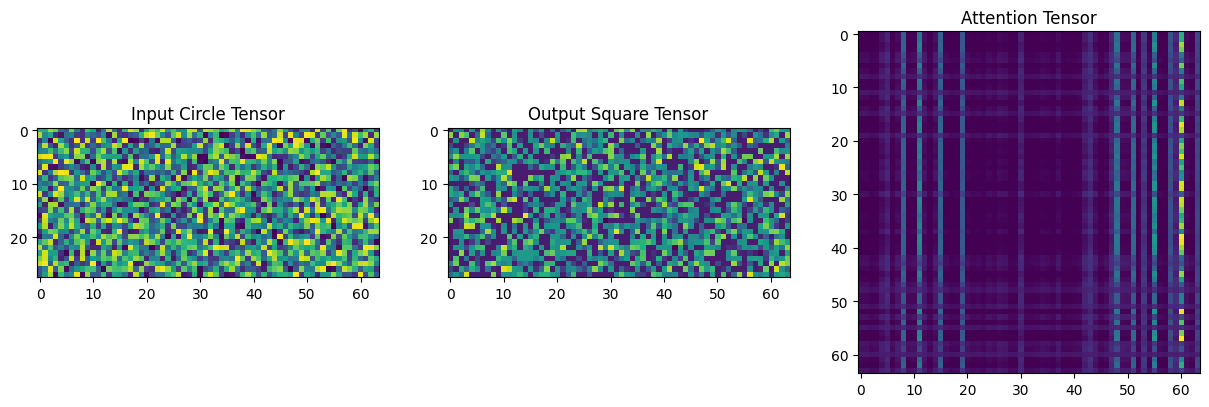

Epoch 30/30, Loss: 0.11905012072250247


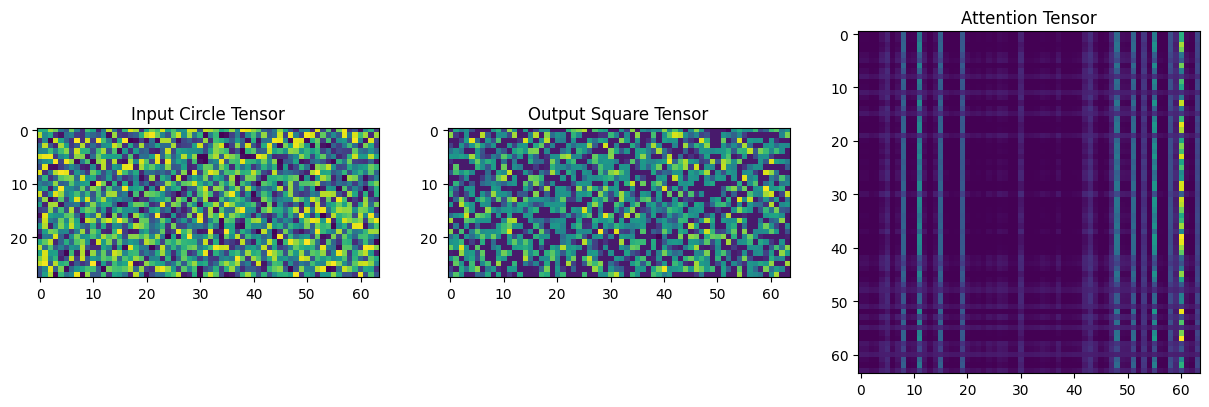

In [52]:
dataset = generate_dataset(2000, 64)

# Initialize and train the model
model = TransformerBlock(embed_size=64, heads=64, dropout=0.3, forward_expansion=4)
train(model, dataset, epochs=30)